In [15]:
import json
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import norse
import matplotlib.pyplot as plt

In [27]:
### TEST DATA
test_data_path = "data/ds_test.pt"
ds_test = torch.load(test_data_path)

letter_written = ['Space', 'A', 'E', 'I', 'O', 'U', 'Y']
device = "cpu"
### LOSS FUNCTION
loss_fn = torch.nn.functional.cross_entropy
### OPTIMAL HYPERPARAMETERS
parameters_path = "data/parameters_ref_zero.json"

with open(parameters_path) as f:
   parameters = json.load(f)

import nir
nir_graph = nir.read("braille_noDelay_noBias_subtract.nir")
nir_graph

NIRGraph(nodes={'fc1': Linear(weight=array([[-7.05236793e-02, -2.61315942e-01, -5.26689172e-01,
        -2.45954826e-01, -4.40458059e-01, -3.80396217e-01,
        -5.68148315e-01, -2.27071315e-01, -9.20756757e-02,
        -4.10928190e-01, -3.07744265e-01, -2.65883446e-01],
       [ 5.01341186e-02, -2.18999848e-01, -1.68351129e-01,
        -3.23840916e-01, -5.61923981e-02, -2.19903871e-01,
        -3.86022836e-01, -1.73844993e-01, -2.75734633e-01,
        -1.64522469e-01, -4.27448958e-01, -1.87260064e-03],
       [-1.02292430e+00, -1.31440580e+00, -1.40579808e+00,
        -1.26523030e+00, -6.06915116e-01, -1.37908447e+00,
        -5.43509364e-01, -1.19199538e+00, -3.49371970e-01,
        -6.08964205e-01, -1.33212364e+00, -1.05917525e+00],
       [ 1.47333503e-01,  4.61688414e-02, -4.52450849e-02,
        -3.77458218e-03,  1.31274452e-02,  3.26349348e-01,
         2.24451181e-02,  4.09200713e-02,  1.35334834e-01,
         3.00461352e-01, -1.31671891e-01, -9.50157762e-01],
       [-2.8271

In [32]:
[type(x) for x in nir_graph.nodes.values()]

[nir.ir.Linear,
 nir.ir.Linear,
 nir.ir.Input,
 nir.ir.CubaLIF,
 nir.ir.Linear,
 nir.ir.CubaLIF,
 nir.ir.Output]

In [33]:
net = norse.torch.from_nir(nir_graph, dt=1e-4)
net

GraphExecutor(
  (fc1): Linear(in_features=40, out_features=12, bias=False)
  (fc2): Linear(in_features=7, out_features=40, bias=False)
  (input): Identity()
  (lif1_lif): CubaLIF(
    (synapse): LIBoxCell(
      p=LIBoxParameters(tau_mem_inv=tensor([2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500.,
              2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500.,
              2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500.,
              2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500.]), v_leak=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])), dt=0.0001
    )
    (lif): LIFBoxCell(
      p=LIFBoxParameters(tau_mem_inv=tensor([1499.9998, 1499.9998, 1499.9998, 1499.9998, 1499.9998, 1499.9998,
              1499.9998, 1499.9998, 1499.9998, 1499.9998, 1499.9998, 1499.9998,
   

In [34]:
nir_graph.nodes.keys()

dict_keys(['fc1', 'fc2', 'input', 'lif1.lif', 'lif1.w_rec', 'lif2', 'output'])

# Save activity of first layer

In [37]:
def record_layer1(graph, reset_method):
    net = norse.torch.from_nir(graph, dt=1e-4, reset_method=reset_method)
    lin_out = net.fc1(ds_test[0][0])
    lin_out.shape
    lif1_out = []
    state = None
    for i, t in enumerate(lin_out):
        if i == 0:
            try:
                t = t + net.lif1_w_rec.bias
            except:
                pass
        else:
            t = net.lif1_w_rec(t)
        z, state = net.lif1_lif(t, state)
        lif1_out.append(z)
    return torch.stack(lif1_out).detach()
zero_out = record_layer1("braille_noDelay_bias_zero.nir", reset_method=norse.torch.functional.reset_value)
zero_out.shape

torch.Size([256, 38])

In [48]:
np.save("norse_activity_noDelay_bias_zero.npy", zero_out.numpy())

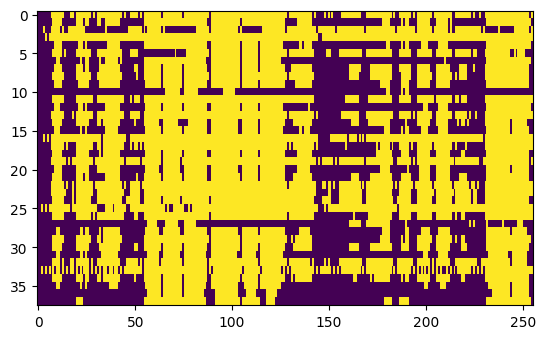

In [39]:
plt.imshow(zero_out.T, interpolation="none", aspect=4)

In [49]:
subtract_out = record_layer1("braille_noDelay_noBias_subtract.nir", reset_method=norse.torch.functional.reset_subtract)
np.save("norse_activity_noDelay_noBias_subtract.npy", subtract_out.numpy())
subtract_out.shape

torch.Size([256, 40])

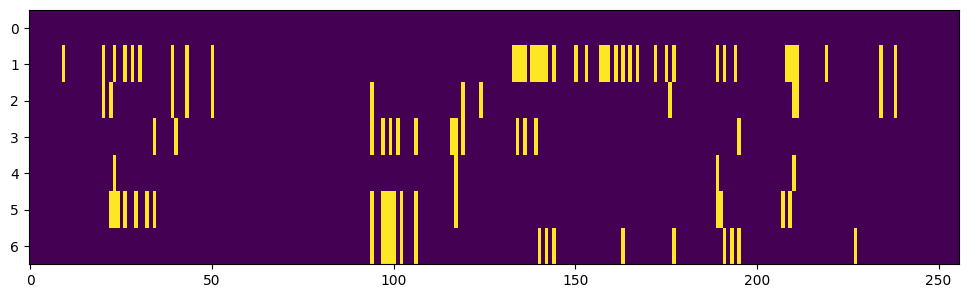

In [41]:
def apply(net, data):
    state = None
    hid_rec = []
    out = []
    for i, t in enumerate(data):
        z, state = net(t, state)
        out.append(z)
        hid_rec.append(state)
    spk_out = torch.stack(out)
    # hid_rec = torch.stack(hid_rec)
    return spk_out, hid_rec
plt.figure(figsize=(12, 4))
plt.imshow(apply(net, ds_test[0][0])[0].detach().T, aspect=10, interpolation="none")

# Run inference

In [42]:
def val_test_loop(dataset, batch_size, net, loss_fn, device, shuffle=True, saved_state_dict=None, label_probabilities=False, regularization=None):
  
  with torch.no_grad():
    if saved_state_dict != None:
        net.load_state_dict(saved_state_dict)
    net.eval()

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

    batch_loss = []
    batch_acc = []

    for data, labels in loader:
        data = data.to(device).swapaxes(1, 0)
        labels = labels.to(device)

        spk_out, hid_rec = apply(net, data)

        # Validation loss
        if regularization != None:
            # L1 loss on spikes per neuron from the hidden layer
            reg_loss = regularization[0]*torch.mean(torch.sum(hid_rec, 0))
            # L2 loss on total number of spikes from the hidden layer
            reg_loss = reg_loss + regularization[1]*torch.mean(torch.sum(torch.sum(hid_rec, dim=0), dim=1)**2)
            loss_val = loss_fn(spk_out, labels) + reg_loss
        else:
            loss_val = loss_fn(spk_out.sum(0), labels)

        batch_loss.append(loss_val.detach().cpu().item())

        # Accuracy
        act_total_out = torch.sum(spk_out, 0)  # sum over time
        _, neuron_max_act_total_out = torch.max(act_total_out, 1)  # argmax over output units to compare to labels
        batch_acc.extend((neuron_max_act_total_out == labels).detach().cpu().numpy()) # batch_acc.append(np.mean((neuron_max_act_total_out == labels).detach().cpu().numpy()))
    
    if label_probabilities:
        log_softmax_fn = nn.LogSoftmax(dim=-1)
        log_p_y = log_softmax_fn(act_total_out)
        return [np.mean(batch_loss), np.mean(batch_acc)], torch.exp(log_p_y)
    else:
        return [np.mean(batch_loss), np.mean(batch_acc)]

In [43]:
### INFERENCE ON TEST SET

batch_size = 64

input_size = 12 
num_steps = next(iter(ds_test))[0].shape[0]
regularization = [parameters["reg_l1"], parameters["reg_l2"]]

In [44]:
def load_and_val(graph, reset_method):
    net = norse.torch.from_nir(graph, reset_method=reset_method, dt=1e-4)
    return val_test_loop(ds_test, batch_size, net, loss_fn, device, shuffle=False)#, regularization=regularization)    

In [45]:
test_results = load_and_val("braille_noDelay_noBias_subtract.nir", reset_method=norse.torch.functional.reset_subtract)
np.save("norse_accuracy_noDelay_noBias_subtract.npy", np.round(test_results[1]*100,2))
print("Test accuracy: {}%".format(np.round(test_results[1]*100,2)))

Test accuracy: 93.57%


In [47]:
test_results = load_and_val("braille_noDelay_bias_zero.nir", reset_method=norse.torch.functional.reset_value)
np.save("norse_accuracy_noDelay_bias_zero.npy", np.round(test_results[1]*100,2))
print("Test accuracy: {}%".format(np.round(test_results[1]*100,2)))

Test accuracy: 94.29%
